In [2]:
import os
import urllib.request
import re


if not os.path.exists("the-verdict"):
    urllib.request.urlretrieve("https://raw.githubusercontent.com/rasbt/LLMs-from-scratch/refs/heads/main/ch02/01_main-chapter-code/the-verdict.txt", 
                   "the-verdict")

In [3]:
with open("the-verdict", "r", encoding = "utf-8") as f:
    raw_text = f.read()

len(raw_text)

20479

In [4]:
preprocessed = re.split(r'([,.:;?_!"()\']|--|\s)', raw_text)
preprocessed = [item.strip() for item in preprocessed if item.strip()]
preprocessed[:20]

['I',
 'HAD',
 'always',
 'thought',
 'Jack',
 'Gisburn',
 'rather',
 'a',
 'cheap',
 'genius',
 '--',
 'though',
 'a',
 'good',
 'fellow',
 'enough',
 '--',
 'so',
 'it',
 'was']

In [5]:
len(preprocessed)

4690

In [6]:
# tokens to token ids

all_words = sorted(set(preprocessed))
vocab_size = len(all_words)
vocab_size

1130

In [7]:
vocab = {word: token for token, word in enumerate(all_words)}
vocab

{'!': 0,
 '"': 1,
 "'": 2,
 '(': 3,
 ')': 4,
 ',': 5,
 '--': 6,
 '.': 7,
 ':': 8,
 ';': 9,
 '?': 10,
 'A': 11,
 'Ah': 12,
 'Among': 13,
 'And': 14,
 'Are': 15,
 'Arrt': 16,
 'As': 17,
 'At': 18,
 'Be': 19,
 'Begin': 20,
 'Burlington': 21,
 'But': 22,
 'By': 23,
 'Carlo': 24,
 'Chicago': 25,
 'Claude': 26,
 'Come': 27,
 'Croft': 28,
 'Destroyed': 29,
 'Devonshire': 30,
 'Don': 31,
 'Dubarry': 32,
 'Emperors': 33,
 'Florence': 34,
 'For': 35,
 'Gallery': 36,
 'Gideon': 37,
 'Gisburn': 38,
 'Gisburns': 39,
 'Grafton': 40,
 'Greek': 41,
 'Grindle': 42,
 'Grindles': 43,
 'HAD': 44,
 'Had': 45,
 'Hang': 46,
 'Has': 47,
 'He': 48,
 'Her': 49,
 'Hermia': 50,
 'His': 51,
 'How': 52,
 'I': 53,
 'If': 54,
 'In': 55,
 'It': 56,
 'Jack': 57,
 'Jove': 58,
 'Just': 59,
 'Lord': 60,
 'Made': 61,
 'Miss': 62,
 'Money': 63,
 'Monte': 64,
 'Moon-dancers': 65,
 'Mr': 66,
 'Mrs': 67,
 'My': 68,
 'Never': 69,
 'No': 70,
 'Now': 71,
 'Nutley': 72,
 'Of': 73,
 'Oh': 74,
 'On': 75,
 'Once': 76,
 'Only': 77,
 '

In [8]:
all_words = sorted(list(set(preprocessed)))
all_words.extend(["<|endoftext|>", "<|unk|>"])
vocab = {word: token for token, word in enumerate(all_words)}
vocab_size = len(all_words)
vocab_size

1132

In [9]:
class SimpleTokenizerV1:
    def __init__(self, vocab):
        self.str_2_int = vocab
        self.int_2_str = {token: word for word, token in vocab.items()}

    def encode(self, text: str):
        preprocessed = re.split(r'([,.:;?_!"()\']|--|\s)', text)
        preprocessed = [
            item if item in self.str_2_int
            else "<|unk|>"
            for item in preprocessed
            ]

        ids = [self.str_2_int[s] for s in preprocessed]
        return ids

    def decoder(self, ids: list):
        text = ' '.join([self.int_2_str[s] for s in ids])
        text = re.sub(r"\s+([,.?!\"'])", r"\1", text)
        return text

tokenozer_v1 = SimpleTokenizerV1(vocab)
text = "hello."
encoded = tokenozer_v1.encode(text)
decoded = tokenozer_v1.decoder(encoded)

print(f"text: {text}")
print(f"encoded: {encoded}")
print(f"decoded: {decoded}")

text: hello.
encoded: [1131, 7, 1131]
decoded: <|unk|>. <|unk|>


In [10]:
# tiktoken
import tiktoken

tokenizer_tik = tiktoken.get_encoding("gpt2")

In [11]:
vocab_size = tokenizer_tik.n_vocab
vocab_size

50257

In [12]:
h = tokenizer_tik.encode(
    "Hello, do you like tea? <|endoftext|> In the sunlit terraces of someunknownPlace.",
    allowed_special={"<|endoftext|>"}
)

decoded = tokenizer_tik.decode(h)
decoded

'Hello, do you like tea? <|endoftext|> In the sunlit terraces of someunknownPlace.'

In [13]:
import torch
from torch.utils.data import DataLoader, Dataset

In [14]:
class GPT_Dataset_V1(Dataset):
    def __init__(self, text, tokenizer, max_length, stride):
        super().__init__()

        self.input_ids  = []
        self.target_ids = []

        self.token_ids = h = tokenizer.encode(text, allowed_special={"<|endoftext|>"})

        for i in range(0, len(self.token_ids) - max_length, stride):
            self.input_ids.append(
                torch.tensor(self.token_ids[i:i + max_length])
            )

            self.target_ids.append(
                torch.tensor(self.token_ids[i + 1: i + max_length + 1])
            )
    
    def __len__(self):
        return len(self.input_ids)
    
    def __getitem__(self, idx):
        return self.input_ids[idx], self.target_ids[idx]
    
gpt_ds_v1 = GPT_Dataset_V1(raw_text, tokenizer_tik, 5, 10)

sample_inputs, sample_targets = next(iter(gpt_ds_v1))
print(tokenizer_tik.decode(sample_inputs.tolist()))
print(tokenizer_tik.decode(sample_targets.tolist()))


I HAD always thought
 HAD always thought Jack


In [15]:
def create_dataloader(text, batch_size = 2, max_length = 256, stride = 128, shuffle = True, drop_last = True, num_workers = 4):
    tokenizer = tiktoken.get_encoding("gpt2")
    dataset = GPT_Dataset_V1(text, tokenizer, max_length, stride)
    # print(type(max_length), type(stride), type(text))
    
    dataloader = DataLoader(
        dataset, 
        batch_size = batch_size, 
        shuffle = shuffle, 
        drop_last = drop_last, 
        num_workers = num_workers)
    
    return dataloader

In [16]:
sample_inputs, sample_targets = next(iter(create_dataloader(raw_text, max_length = 10, num_workers = 0, batch_size = 8)))
sample_inputs

tensor([[  198,  1544, 13818,  4622,    11,  1231, 35987,    11,   290,  7121],
        [  329,   502,     0,   383,   520,  5493,    82,  1302,  3436,    11],
        [  284,  1234,  8737,   656, 19133,   553,   373,   530,   286,   262],
        [11061,   340,    11,  3114,   510,   379,   262,  4286,  2029,   262],
        [ 4150,     8,  3688,   284,   402,   271, 10899,   338, 12036,    13],
        [   40,   367,  2885,  1464,  1807,  3619,   402,   271, 10899,  2138],
        [ 6164,    25,   366, 16773,   290,   766,   262,  1334,   286,   262],
        [  314,   550,  1775,   683,    11,   523,  1690,    11,  1615,  3364]])

In [17]:
sample_targets

tensor([[ 1544, 13818,  4622,    11,  1231, 35987,    11,   290,  7121,   530],
        [  502,     0,   383,   520,  5493,    82,  1302,  3436,    11,   290],
        [ 1234,  8737,   656, 19133,   553,   373,   530,   286,   262,  7877],
        [  340,    11,  3114,   510,   379,   262,  4286,  2029,   262, 18205],
        [    8,  3688,   284,   402,   271, 10899,   338, 12036,    13,   843],
        [  367,  2885,  1464,  1807,  3619,   402,   271, 10899,  2138,   257],
        [   25,   366, 16773,   290,   766,   262,  1334,   286,   262,  2156],
        [  550,  1775,   683,    11,   523,  1690,    11,  1615,  3364,   739]])

In [18]:
s = torch.nn.Embedding(5, 2)
s.weight

Parameter containing:
tensor([[-0.0089, -0.2888],
        [ 0.2008,  0.5784],
        [-0.3331,  1.3194],
        [ 0.0572,  1.0601],
        [ 2.6088,  0.5124]], requires_grad=True)

In [19]:
s(torch.tensor([2,3]))

tensor([[-0.3331,  1.3194],
        [ 0.0572,  1.0601]], grad_fn=<EmbeddingBackward0>)

In [20]:
# embeddings
batch_size = 8
max_length = 4

inputs, targets = next(iter(create_dataloader(raw_text, max_length = max_length, stride = max_length, num_workers = 0, batch_size = batch_size, shuffle=False)))
inputs

tensor([[   40,   367,  2885,  1464],
        [ 1807,  3619,   402,   271],
        [10899,  2138,   257,  7026],
        [15632,   438,  2016,   257],
        [  922,  5891,  1576,   438],
        [  568,   340,   373,   645],
        [ 1049,  5975,   284,   502],
        [  284,  3285,   326,    11]])

In [21]:
inputs.shape

torch.Size([8, 4])

In [22]:
vocab_size = tokenizer_tik.n_vocab # 50257
output_dim = 256

embedding_layer = torch.nn.Embedding(vocab_size, output_dim)
embedding_layer.weight

Parameter containing:
tensor([[ 0.2423, -2.6854, -0.0962,  ...,  0.1055, -0.0717,  0.0545],
        [ 1.1800,  0.2918,  1.8987,  ..., -0.6808, -1.1937,  1.2362],
        [-0.3189, -0.9488,  0.1329,  ...,  0.6572,  0.1860, -0.7289],
        ...,
        [ 2.0024,  0.4197,  0.0613,  ..., -0.7455,  0.0423,  0.0430],
        [-0.0386,  0.8267, -0.2990,  ..., -1.8636,  0.3962,  0.0923],
        [-0.2633,  0.8132,  0.7642,  ...,  0.3050, -0.0199,  2.7173]],
       requires_grad=True)

In [23]:
embedding_layer.weight.shape

torch.Size([50257, 256])

In [24]:
token_embedding = embedding_layer(inputs)
token_embedding.shape

torch.Size([8, 4, 256])

In [25]:
position_embedding_layer = torch.nn.Embedding(max_length, output_dim)
position_embedding_layer.weight.shape

torch.Size([4, 256])

In [26]:
pos_embedding = position_embedding_layer(torch.arange(max_length))
pos_embedding.shape

torch.Size([4, 256])

In [27]:
input_embedding = token_embedding + pos_embedding
input_embedding.shape

torch.Size([8, 4, 256])

In [28]:
# Attention mechanics without trainable weights
inputs = torch.tensor([
    [0.43, 0.15, 0.89],   # Your    (x^1)
    [0.55, 0.87, 0.66],   # journey (x^2)
    [0.57, 0.85, 0.64],   # starts  (x^3)
    [0.22, 0.58, 0.33],   # with    (x^4)
    [0.77, 0.25, 0.10],   # one     (x^5)
    [0.05, 0.80, 0.55],   # step    (x^6)
])

In [29]:
attn_weights = torch.softmax(inputs @ inputs.T, dim = 1)
attn_weights

tensor([[0.2098, 0.2006, 0.1981, 0.1242, 0.1220, 0.1452],
        [0.1385, 0.2379, 0.2333, 0.1240, 0.1082, 0.1581],
        [0.1390, 0.2369, 0.2326, 0.1242, 0.1108, 0.1565],
        [0.1435, 0.2074, 0.2046, 0.1462, 0.1263, 0.1720],
        [0.1526, 0.1958, 0.1975, 0.1367, 0.1879, 0.1295],
        [0.1385, 0.2184, 0.2128, 0.1420, 0.0988, 0.1896]])

In [30]:
context_vectors = attn_weights @ inputs
context_vectors

tensor([[0.4421, 0.5931, 0.5790],
        [0.4419, 0.6515, 0.5683],
        [0.4431, 0.6496, 0.5671],
        [0.4304, 0.6298, 0.5510],
        [0.4671, 0.5910, 0.5266],
        [0.4177, 0.6503, 0.5645]])

In [31]:
# Attention mechanics with trainable weights

d_in = inputs.shape[1] # 3
d_out = 2

torch.manual_seed(123)

W_key   = torch.nn.Parameter(torch.rand(d_in, d_out))
W_query = torch.nn.Parameter(torch.rand(d_in, d_out))
W_value = torch.nn.Parameter(torch.rand(d_in, d_out))

keys = inputs @ W_key
queries = inputs @ W_query
values = inputs @ W_value

In [32]:
attn_score = queries @ keys.T
attn_score

tensor([[0.9231, 1.2705, 1.2544, 0.6973, 0.6114, 0.8995],
        [1.3545, 1.8524, 1.8284, 1.0167, 0.8819, 1.3165],
        [1.3241, 1.8111, 1.7877, 0.9941, 0.8626, 1.2871],
        [0.7910, 1.0795, 1.0654, 0.5925, 0.5121, 0.7682],
        [0.4032, 0.5577, 0.5508, 0.3061, 0.2707, 0.3937],
        [1.1330, 1.5440, 1.5238, 0.8475, 0.7307, 1.0996]],
       grad_fn=<MmBackward0>)

In [33]:
attn_weights = torch.softmax(attn_score / d_out**0.5, dim = 1)
attn_weights

tensor([[0.1618, 0.2068, 0.2045, 0.1379, 0.1298, 0.1591],
        [0.1588, 0.2258, 0.2220, 0.1251, 0.1137, 0.1546],
        [0.1591, 0.2245, 0.2208, 0.1260, 0.1148, 0.1550],
        [0.1635, 0.2006, 0.1986, 0.1421, 0.1343, 0.1609],
        [0.1649, 0.1840, 0.1831, 0.1540, 0.1502, 0.1638],
        [0.1612, 0.2156, 0.2126, 0.1318, 0.1213, 0.1575]],
       grad_fn=<SoftmaxBackward0>)

In [34]:
context_vectors = attn_weights @ values
context_vectors

tensor([[0.2947, 0.7956],
        [0.3015, 0.8132],
        [0.3010, 0.8120],
        [0.2925, 0.7902],
        [0.2863, 0.7737],
        [0.2979, 0.8043]], grad_fn=<MmBackward0>)

In [35]:
class Self_attention_v1(torch.nn.Module):
    def __init__(self, d_in, d_out):
        super().__init__()

        self.d_out     = d_out
        self.W_keys    = torch.nn.Linear(d_in, d_out)
        self.W_queries = torch.nn.Linear(d_in, d_out)
        self.W_values  = torch.nn.Linear(d_in, d_out)


    def forward(self, inputs):
        
        querys = self.W_queries(inputs)
        keys   = self.W_keys(inputs)
        values = self.W_values(inputs)

        attn_scores = querys @ keys.T
        attn_weights = torch.softmax(attn_scores / self.d_out**0.5, dim = 1)
        context_vectors = attn_weights @ values

        return context_vectors

torch.manual_seed(5)

sa = Self_attention_v1(3, 2)
sa(inputs)

tensor([[-0.4562,  0.5104],
        [-0.4659,  0.5034],
        [-0.4656,  0.5036],
        [-0.4644,  0.5045],
        [-0.4590,  0.5080],
        [-0.4676,  0.5023]], grad_fn=<MmBackward0>)

In [36]:
querys = sa.W_queries(inputs)
keys   = sa.W_keys(inputs)
values = sa.W_values(inputs)

attn_scores = querys @ keys.T
attn_weights = torch.softmax(attn_scores / sa.d_out**0.5, dim = 1)

masked_attn_weights = torch.tril(torch.ones(attn_weights.shape[0], attn_weights.shape[0])) * attn_weights # doesnt sum up to one
masked_attn_weights

tensor([[0.1662, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.1987, 0.1625, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.1971, 0.1627, 0.1630, 0.0000, 0.0000, 0.0000],
        [0.1945, 0.1635, 0.1638, 0.1562, 0.0000, 0.0000],
        [0.1643, 0.1673, 0.1674, 0.1669, 0.1674, 0.0000],
        [0.2104, 0.1612, 0.1616, 0.1509, 0.1682, 0.1476]],
       grad_fn=<MulBackward0>)

In [37]:
masked_simple_norm = masked_attn_weights / masked_attn_weights.sum(dim=1, keepdim=True) # sum up to one
masked_simple_norm

tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5501, 0.4499, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3771, 0.3112, 0.3117, 0.0000, 0.0000, 0.0000],
        [0.2868, 0.2411, 0.2416, 0.2304, 0.0000, 0.0000],
        [0.1971, 0.2008, 0.2008, 0.2004, 0.2008, 0.0000],
        [0.2104, 0.1612, 0.1616, 0.1509, 0.1682, 0.1476]],
       grad_fn=<DivBackward0>)

In [38]:
# Simpler approach
attn_scores

tensor([[ 0.0516,  0.0783,  0.0812,  0.0205,  0.1030, -0.0028],
        [ 0.0493, -0.2352, -0.2328, -0.2973, -0.1936, -0.3178],
        [ 0.0470, -0.2246, -0.2222, -0.2837, -0.1849, -0.3032],
        [ 0.0522, -0.1932, -0.1906, -0.2577, -0.1524, -0.2796],
        [ 0.0034,  0.0296,  0.0298,  0.0263,  0.0298,  0.0246],
        [ 0.0749, -0.3017, -0.2978, -0.3948, -0.2416, -0.4261]],
       grad_fn=<MmBackward0>)

In [39]:
d_out

2

In [40]:
mask = torch.triu(torch.ones(attn_weights.shape[0], attn_weights.shape[0]), diagonal=1)
masked = attn_scores.masked_fill(mask.bool(), - torch.inf)
attn_weights = torch.softmax(masked / d_out**0.5, dim=1)
layer_dropout = torch.nn.Dropout(0.5)
attn_weights = layer_dropout(attn_weights)
attn_weights

tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.6224, 0.6234, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.4832, 0.4608, 0.0000, 0.0000],
        [0.3943, 0.0000, 0.4017, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.3364, 0.2953]],
       grad_fn=<MulBackward0>)

In [41]:
attn_weights.sum(1, keepdim=True)

tensor([[0.0000],
        [0.0000],
        [1.2458],
        [0.9440],
        [0.7960],
        [0.6316]], grad_fn=<SumBackward1>)

In [42]:
class Causal_attention(torch.nn.Module):
    def __init__(self, d_in, d_out, context_length, dropout, qkv_bias = False):
        super().__init__()

        self.d_out     = d_out
        self.W_keys    = torch.nn.Linear(d_in, d_out, bias = qkv_bias)
        self.W_queries = torch.nn.Linear(d_in, d_out, bias = qkv_bias)
        self.W_values  = torch.nn.Linear(d_in, d_out, bias = qkv_bias)
        self.dropout   = torch.nn.Dropout(dropout)
        self.register_buffer("mask", torch.triu(torch.ones(context_length, context_length), diagonal=1))

    def forward(self, inputs):
        batch, num_tokens, d_in = inputs.shape
        querys = self.W_queries(inputs)
        keys   = self.W_keys(inputs)
        values = self.W_values(inputs)

        attn_scores = querys @ keys.transpose(1,2)
        attn_scores = attn_scores.masked_fill(self.mask.bool()[:num_tokens, :num_tokens], - torch.inf)
        attn_weights = torch.softmax(attn_scores / self.d_out**0.5, dim = 1)
        attn_weights = self.dropout(attn_weights)
        context_vectors = attn_weights @ values
        return context_vectors

torch.manual_seed(5)
if len(inputs.shape) != 3: inputs = torch.stack((inputs, inputs))
ca = Causal_attention(3, 2, context_length = 6, dropout = 0.0)
ca(inputs).shape

torch.Size([2, 6, 2])

In [43]:
inputs.shape

torch.Size([2, 6, 3])

In [44]:
class Multihead_Attention(torch.nn.Module):
    def __init__(self, d_in, d_out, context_length, dropout, qkv_bias = False, num_heads = 2):
        super().__init__()
        self.heads = torch.nn.ModuleList(
                        [Causal_attention(d_in, d_out, context_length = context_length, dropout = dropout) for _ in range(num_heads)
                    ])
    def forward(self, inputs):
        return torch.cat([head(inputs) for head in self.heads], dim = -1)
    
ma = Multihead_Attention(3, 2, context_length = 6, dropout = 0.0, qkv_bias=False, num_heads=2)
ma(inputs).shape

torch.Size([2, 6, 4])

In [45]:
ma(inputs)

tensor([[[-0.1135,  0.0497,  0.0944, -0.0486],
         [-0.2730,  0.1452,  0.1812, -0.1157],
         [-0.4732,  0.2627,  0.2877, -0.1968],
         [-0.6024,  0.3529,  0.3261, -0.2437],
         [-0.8042,  0.4074,  0.4937, -0.3022],
         [-1.3560,  0.8358,  0.6603, -0.5475]],

        [[-0.1135,  0.0497,  0.0944, -0.0486],
         [-0.2730,  0.1452,  0.1812, -0.1157],
         [-0.4732,  0.2627,  0.2877, -0.1968],
         [-0.6024,  0.3529,  0.3261, -0.2437],
         [-0.8042,  0.4074,  0.4937, -0.3022],
         [-1.3560,  0.8358,  0.6603, -0.5475]]], grad_fn=<CatBackward0>)

In [46]:
class MutliHeadAttention(torch.nn.Module):
    def __init__(self, d_in, d_out, context_length, dropout, qkv_bias = False, num_heads = 2):
        super().__init__()

        assert (d_out % num_heads == 0), "d_out must be divisible by num_heads"


        self.d_out     = d_out
        self.num_heads = num_heads
        self.head_dim  = d_out // num_heads

        self.W_keys    = torch.nn.Linear(d_in, d_out, bias = qkv_bias)
        self.W_queries = torch.nn.Linear(d_in, d_out, bias = qkv_bias)
        self.W_values  = torch.nn.Linear(d_in, d_out, bias = qkv_bias)
        
        self.out_proj  = torch.nn.Linear(d_out, d_out) 
        self.dropout   = torch.nn.Dropout(dropout)
        self.register_buffer("mask", 
                             torch.triu(torch.ones(context_length, context_length), diagonal=1)
                             )
        
    def forward(self, inputs):
        batch, num_tokens, d_in = inputs.shape
        
        keys   = self.W_keys(inputs)
        querys = self.W_queries(inputs)
        values = self.W_values(inputs)

        # Splitting
        # (b, num_tokens, d_out) -> (b, num_tokens, num_heads, head_dim)
        keys   = keys.view(batch, num_tokens, self.num_heads, self.head_dim)
        querys = querys.view(batch, num_tokens, self.num_heads, self.head_dim)
        values = values.view(batch, num_tokens, self.num_heads, self.head_dim)


        keys   = keys.transpose(1,2)   # (batch, num_tokens, num_heads, head_dim) -> (batch, num_heads, num_tokens, head_dim)
        querys = querys.transpose(1,2) # (batch, num_tokens, num_heads, head_dim) -> (batch, num_heads, num_tokens, head_dim)
        values = values.transpose(1,2) # (batch, num_tokens, num_heads, head_dim) -> (batch, num_heads, num_tokens, head_dim)


        attn_scores = querys @ keys.transpose(2,3)                  # self attention
        attn_scores.masked_fill_(                   
            self.mask.bool()[:num_tokens, :num_tokens], - torch.inf # Causal attention
            )
        
        attn_weights = torch.softmax(attn_scores / self.d_out**0.5, dim = 1) # Normalizing
        attn_weights = self.dropout(attn_weights)
        context_vectors = (attn_weights @ values).transpose(1,2) # (batch, num_heads, num_tokens, head_dim) -> (batch, num_tokens, num_heads, head_dim)
        context_vectors = context_vectors.contiguous().view(batch, num_tokens, d_out) # Combining it back to a concatinated form

        return context_vectors
    
mha = Multihead_Attention(d_in = 3, d_out = 2, context_length = 6, dropout = 0.0, qkv_bias=False, num_heads=2)
mha(inputs)

tensor([[[ 0.0823, -0.0646, -0.0309, -0.0465],
         [ 0.1728, -0.0572, -0.0991, -0.0789],
         [ 0.2974, -0.0628, -0.1807, -0.1229],
         [ 0.4328, -0.0428, -0.2726, -0.1489],
         [ 0.5090, -0.1463, -0.1738, -0.2079],
         [ 0.9512,  0.0306, -0.6808, -0.2951]],

        [[ 0.0823, -0.0646, -0.0309, -0.0465],
         [ 0.1728, -0.0572, -0.0991, -0.0789],
         [ 0.2974, -0.0628, -0.1807, -0.1229],
         [ 0.4328, -0.0428, -0.2726, -0.1489],
         [ 0.5090, -0.1463, -0.1738, -0.2079],
         [ 0.9512,  0.0306, -0.6808, -0.2951]]], grad_fn=<CatBackward0>)

In [47]:
mha(inputs).shape

torch.Size([2, 6, 4])

In [59]:
class LayerNorm(torch.nn.Module):
    def __init__(self, embed_dim):
        super().__init__()

        self.scale = torch.nn.Parameter(torch.ones(embed_dim))
        self.shift = torch.nn.Parameter(torch.zeros(embed_dim))
        self.eps = 1e-5
    
    def forward(self, x: torch.tensor):
        mean = x.mean(dim = -1, keepdim = True)
        var  = x.var(dim = -1, keepdim = True, unbiased = False)
        norm = (x - mean) / (torch.sqrt(var) + self.eps)
        return (self.scale * norm) + self.shift
    
ln = LayerNorm(10)
out = ln(torch.rand(2,10))
out.mean(dim = -1, keepdim=True)

tensor([[ 0.0000e+00],
        [-1.5497e-07]], grad_fn=<MeanBackward1>)

In [60]:
out.var(dim = -1, keepdim=True)

tensor([[1.1109],
        [1.1110]], grad_fn=<VarBackward0>)

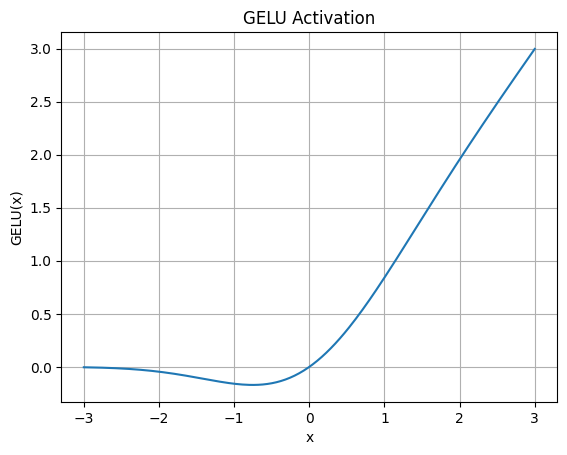

In [74]:
import torch
import matplotlib.pyplot as plt

class GELU(torch.nn.Module):
    def __init__(self):
        super().__init__()
    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(
            torch.sqrt(torch.tensor(2.0 / torch.pi)) * 
            (x + 0.044715 * torch.pow(x, 3))
        ))

gelu = GELU()
x = torch.linspace(-3, 3, 200)
y = gelu(x)

plt.plot(x.numpy(), y.detach().numpy())
plt.grid()
plt.title("GELU Activation")
plt.xlabel("x")
plt.ylabel("GELU(x)")
plt.show()

In [50]:
GPT_config = {
    "vocab_size"     : tokenizer_tik.n_vocab, # 50257
    "context_length" : 1024,                  # The maximum number of tokens the model can process at once
    "embedding_dim"  : 768,                   # The number of features used to represent each token 
    "n_heads"        : 12,
    "n_layers"       : 12,                    # How many transformer blocks
    "drop_rate"      : 0.1,
    "qkv_bias"       : False
}

In [76]:
class Feedforward(torch.nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.layers = torch.nn.Sequential(
                      torch.nn.Linear(cfg["embedding_dim"], 4*cfg["embedding_dim"]),
                      GELU(),
                      torch.nn.Linear(4*cfg["embedding_dim"], cfg["embedding_dim"])
                    )
    def forward(self, x):
        return self.layers(x)
    
ffn = Feedforward(GPT_config)
ffn(torch.rand(5, GPT_config["embedding_dim"])).shape

torch.Size([5, 768])